In [1]:
import numpy as np
import pytest
import os
import cv2
import matplotlib.pyplot as plt
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import onnxruntime
from typing import Tuple, List, Dict, Any



In [2]:

def remove_non_court(input_rgb, encoder_ort_session, decoder_ort_session):
    """
    Removes non-court pixels from an input RGB image using the SAM model.
    
    Args:
        input_rgb (np.ndarray): Input RGB image as a numpy array with shape (H, W, 3)
        ort_session: ONNX Runtime session with loaded SAM model
        
    Returns:
        np.ndarray: RGB image with non-court pixels masked out
    """
    # Check if input is valid
    if input_rgb is None or input_rgb.size == 0:
        print("Error: Invalid input image")
        return None
    
    # 1. Preprocess image for SAM
    preprocessed_image = preprocess_image(input_rgb)
    
    # 2. Get image embedding using SAM encoder
    image_embedding = get_image_embedding(preprocessed_image, encoder_ort_session)
    
    # 3. Generate prompts for court detection
    # We'll use both point prompts and box prompts for better accuracy
    prompts = []
    
    # plt
    plt.imshow(input_rgb)
    plt.show()

    prompts = {"points": np.array([[600, 140]])}
    # 4. Run SAM model with prompts to get masks
    masks = run_sam_prediction(input_rgb.shape, image_embedding, prompts, decoder_ort_session)


    
    # 5. Post-process masks to get the best court mask
    court_mask = post_process_masks(masks, input_rgb.shape[:2])
    
    # 6. Apply the mask to the original image
    masked_image = apply_mask(input_rgb, court_mask)
    
    # Optional: Visualize the result
    # visualize_result(input_rgb, masked_image, court_mask)
    
    return masked_image, court_mask


def preprocess_image(image: np.ndarray) -> np.ndarray:
    """
    Preprocess the image for SAM model input.
    
    Args:
        image: RGB image as numpy array (H, W, 3)
        
    Returns:
        Preprocessed image ready for SAM encoder
    """
    # Resize if needed (SAM works best with input of size 1024x1024)
    target_size = 1024
    h, w = image.shape[:2]
    
    # Calculate resize ratio
    resize_ratio = min(target_size / h, target_size / w)
    new_h, new_w = int(h * resize_ratio), int(w * resize_ratio)
    
    # Resize image
    resized_image = cv2.resize(image, (new_w, new_h))
    
    # Pad to square if needed
    padded_image = np.zeros((target_size, target_size, 3), dtype=np.uint8)
    padded_image[:new_h, :new_w, :] = resized_image
    
    # Normalize pixel values to [0, 1]
    normalized_image = padded_image.astype(np.float32) / 255.0
    
    # Convert from RGB to BGR if needed and apply SAM normalization
    # SAM uses different normalization than typical PyTorch models
    pixel_mean = np.array([0.485, 0.456, 0.406])
    pixel_std = np.array([0.229, 0.224, 0.225])
    normalized_image = (normalized_image - pixel_mean) / pixel_std
    
    # plt
    plt.imshow(resized_image)
    plt.title('resized image')
    plt.show()
    # Transpose to (C, H, W) format
    transposed_image = normalized_image.transpose(2, 0, 1)
    
    # Add batch dimension
    batched_image = np.expand_dims(transposed_image, axis=0)
    
    return batched_image


def get_image_embedding(preprocessed_image: np.ndarray, ort_session) -> np.ndarray:
    """
    Get image embedding using the SAM encoder.
    
    Args:
        preprocessed_image: Preprocessed image as numpy array
        ort_session: ONNX Runtime session
        
    Returns:
        Image embedding from SAM encoder
    """
    # Get model input and output names
    
    # Run the model
    embedding = ort_session.run(None, {"images": preprocessed_image.astype(np.float32)})[0]
    
    return embedding

def run_sam_prediction(original_size, embedding: np.ndarray, prompts: Dict[str, Any], ort_session) -> List[np.ndarray]:
    """
    Run SAM prediction with the provided embedding and prompts.
    
    Args:
        embedding: Image embedding from SAM encoder
        prompts: Dictionary containing point and box prompts
        ort_session: ONNX Runtime session
    
    Returns:
        List of predicted masks
    """
    # Prepare inputs for the decoder
    # Format depends on the specific SAM ONNX model being used
    
    # Default values for other parameters
    input_dict = {
        'image_embeddings': embedding,
        'has_mask_input': np.array([0], dtype=np.float32),  # No previous mask
        'mask_input': np.zeros((1, 1, 256, 256), dtype=np.float32),  # Empty mask input
        'orig_im_size': np.array([original_size[1], original_size[0]], dtype=np.float32),
    }
    
    # Add point prompts if available
    if 'points' in prompts:
        points = prompts['points']
        onnx_coords = np.concatenate([points, np.array([[0.0,0.0]])], axis=0)[None, :,:].astype(np.float32)
        onnx_labels = np.concatenate([np.array([1]), np.array([-1])])[None, :].astype(np.float32)
        # import copy
        # coords = copy.deepcopy(onnx_coords).astype(float)
        # coords[..., 0] = coords[..., 0] * 

        input_dict['point_coords'] = onnx_coords
        input_dict['point_labels'] = onnx_labels



    
    # Get output from decoder
    try:
        # Adjust these based on your specific ONNX model's input/output names
        outputs = ort_session.run(None, input_dict)
        
        # Process the output masks
        masks = outputs[0]  # Assuming first output is masks
        scores = outputs[1]  # Assuming second output is scores
        print("second: ", scores)
        
        return masks
    except Exception as e:
        print(f"Error running SAM model: {e}")
        return []


def post_process_masks(masks: List[np.ndarray], original_shape: Tuple[int, int]) -> np.ndarray:
    """
    Post-process SAM masks to get the best court mask.
    
    Args:
        masks: List of predicted masks from SAM
        original_shape: Original image shape (H, W)
        
    Returns:
        Best court mask at original image resolution
    """
    if masks is None or len(masks) == 0:
        # Return empty mask if no predictions
        return np.zeros(original_shape, dtype=np.uint8)
    
    # Select the mask with the highest score (first mask in sorted list)
    best_mask = masks[0].squeeze()

    print("best mask shape is: ", best_mask.shape)
    
    # Resize to original dimensions
    best_mask = best_mask.astype(np.uint8) * 255  # Convert to uint8
    best_mask = cv2.resize(best_mask, (original_shape[1], original_shape[0]))

    # plt
    plt.imshow(best_mask)
    plt.show()
    
    # Threshold to get binary mask
    _, binary_mask = cv2.threshold(best_mask, 127, 255, cv2.THRESH_BINARY)
    
    # Further refine the mask using morphological operations
    kernel = np.ones((5, 5), np.uint8)
    refined_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_OPEN, kernel)
    
    return refined_mask


def apply_mask(image: np.ndarray, mask: np.ndarray) -> np.ndarray:
    """
    Apply mask to the image to keep only court pixels.
    
    Args:
        image: Original RGB image
        mask: Binary mask where 255 is court and 0 is non-court
        
    Returns:
        Masked RGB image with only court pixels
    """
    # Create a 3-channel mask
    mask_3channel = cv2.merge([mask, mask, mask])
    
    # Apply the mask
    masked_image = cv2.bitwise_and(image, mask_3channel)
    
    # Optional: Set non-court pixels to a specific color (e.g., black)
    # masked_image[mask_3channel == 0] = [0, 0, 0]  # Set to black
    
    return masked_image


def visualize_result(original: np.ndarray, masked: np.ndarray, mask: np.ndarray) -> None:
    """
    Visualize the original image, mask, and masked image
    
    Args:
        original: Original RGB image
        masked: Masked RGB image
        mask: Binary mask
    """
    # Create a figure with 3 subplots
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original)
    plt.axis('off')
    
    # Mask
    plt.subplot(1, 3, 2)
    plt.title("Court Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
    # Masked image
    plt.subplot(1, 3, 3)
    plt.title("Court Only")
    plt.imshow(masked)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [3]:
current_dir = "./"
de_onnx_model_path = os.path.join(current_dir, "../vit_l_decoder.onnx")
en_onnx_model_path = os.path.join(current_dir, "../vit_l_encoder.onnx")

decoder_ort_session = onnxruntime.InferenceSession(de_onnx_model_path)
encoder_ort_session = onnxruntime.InferenceSession(en_onnx_model_path)

target w,h is : 1600 2400


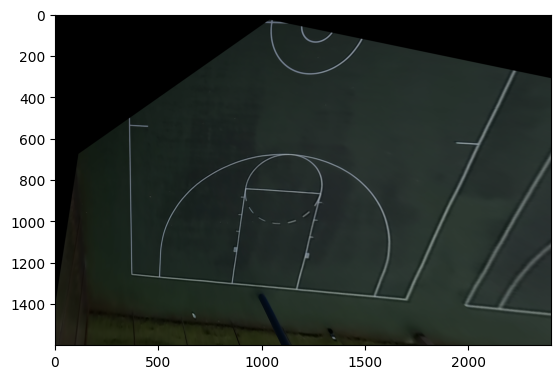

In [4]:
right_img_path = os.path.join(current_dir, "left_img_remapped.png")
right_img_full = cv2.imread(right_img_path)
right_img = right_img_full[:1600, :2400]
resize_ratio = 1
w, h = (
    int(right_img.shape[0] * resize_ratio),
    int(right_img.shape[1] * resize_ratio),
)
print("target w,h is :", w, h)
right_img = cv2.resize(right_img, (h, w))

plt.imshow(right_img)
plt.show()



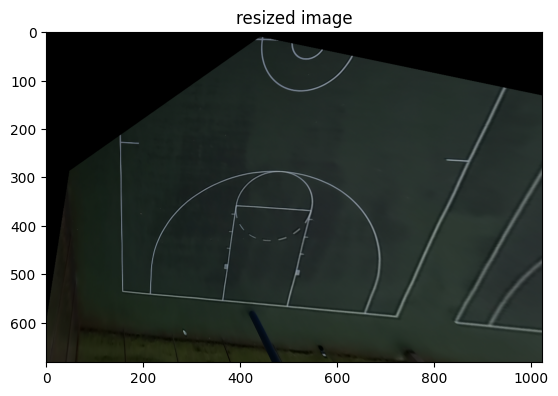

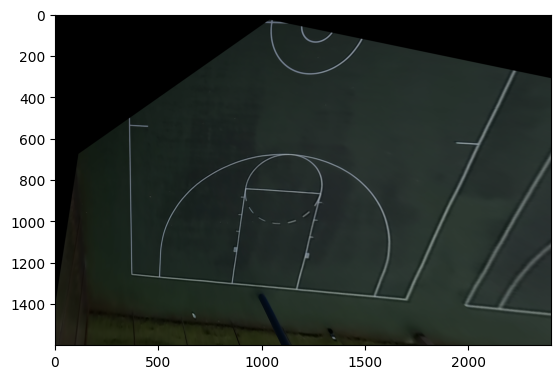

second:  [[0.99748445]]
best mask shape is:  (2400, 1600)


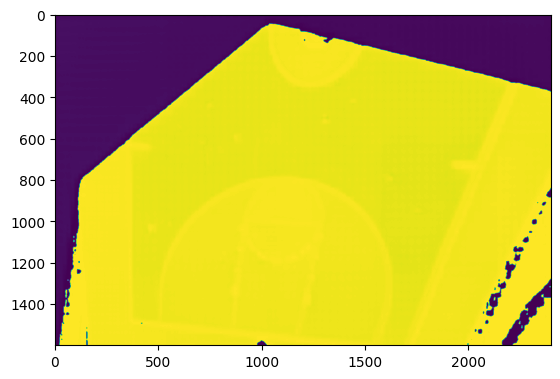

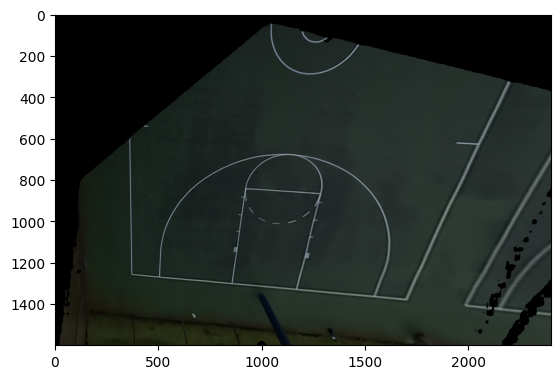

In [5]:

right_img, mask = remove_non_court(right_img, encoder_ort_session, decoder_ort_session)

plt.imshow(right_img)

In [6]:
mask.shape

(1600, 2400)

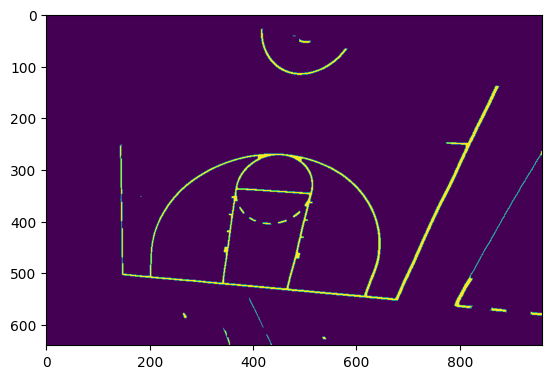

In [7]:
# %% mask

edge_size = (int(h * 0.4), int(w * 0.4))

right_img_gray = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)
# run same
right_img_gray = cv2.resize(right_img_gray, (int( h * 0.4), int(w * 0.4)))
right_edge = cv2.Canny(right_img_gray, 100, 200)

resized_mask = cv2.resize(mask, edge_size)
# erode resized_mask
# erode kernel
kernel = np.ones((15, 15), np.uint8)
semantic_mask = cv2.erode(resized_mask, kernel, iterations=1)
masked_edge = cv2.bitwise_and(right_edge, semantic_mask)

kernel = np.ones((5, 5), np.uint8)
masked_edge = cv2.dilate(masked_edge, kernel, iterations=1)

kernel = np.ones((5, 5), np.uint8)
masked_edge = cv2.erode(masked_edge, kernel, iterations=1)
# right_edge = cv2.resize(right_edge, (int(h * 0.4), int(w * 0.4)))
# right_edge = right_edge[:100, :230]
plt.imshow(masked_edge)

# remove straight edge

detected 28 lines
Detected and removed 28 lines longer than 25 pixels


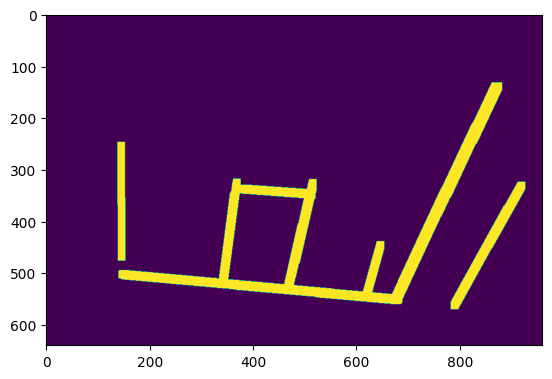

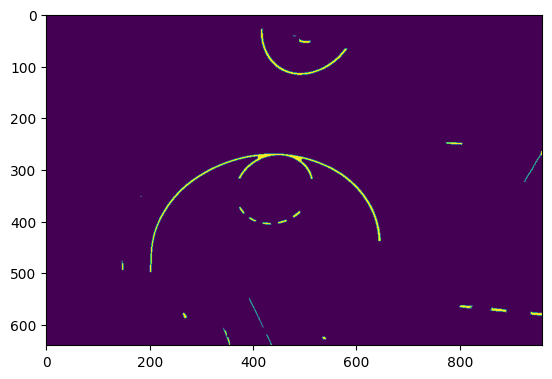

In [8]:
edge_without_lines = masked_edge

# Run Hough line detection
lines = cv2.HoughLinesP(
    masked_edge,
    rho=1,
    theta=np.pi / 360,
    threshold=20,  # Threshold for line detection
    minLineLength=100,  # Min line length as specified in TODO
    maxLineGap=10,  # Max gap between line segments to connect them
)

print(f"detected {len(lines)} lines")

# Create a blank image to draw the lines
line_mask = np.zeros_like(masked_edge)

# If lines are detected
line_count = 0
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Calculate line length
        length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        if length > 100:
            # Draw the line on the mask with some thickness to ensure we remove it completely
            cv2.line(line_mask, (x1, y1), (x2, y2), 255, 1)
            line_count += 1

print(f"Detected and removed {line_count} lines longer than 25 pixels")

# dilate the line
kernel = np.ones((15, 15), np.uint8)
semantic_mask = cv2.dilate(line_mask, kernel, iterations=1)
edge_without_lines[semantic_mask > 0] = 0
plt.imshow(semantic_mask)
plt.show()

plt.imshow(edge_without_lines)
plt.show()


# Group lines Vertically and horizontally

In [9]:
import math
def classify_court_elements(circle, lines, center_no_go_offset, corners):

    # Classify lines as horizontal/vertical
    h_lines, v_lines = [], []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        
        # Calculate line angle
        if abs(x2 - x1) > 0.000000000000001:
            angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        else:
            continue
        
        # Horizontal: -angle_thresh to +angle_thresh degrees
        # Vertical: 90-angle_thresh to 90+angle_thresh degrees
        if abs(angle) < 30:
            h_lines.append(line[0])
        elif abs(abs(angle) - 90) < 30:
            v_lines.append(line[0])

    # Classify horizontal lines (baseline should be lower)
    h_lines = sorted(h_lines, key=lambda line: (line[1] + line[3]) / 2)
    v_lines = sorted(v_lines, key=lambda line: (line[0] + line[2]) / 2)
    print("vertical lines:", v_lines)


    # Select the most promising 3-point arc circle
    if circle is not None:
        center_x, center_y = circle[0], circle[1]
    else:
        # Fallback if no circle detected
        # find the center of between the left most to right most vertical lines
        center_x = (v_lines[0][0] + v_lines[-1][0]) / 2
        center_y = (h_lines[0][1] + h_lines[-1][1]) / 2
    
    # Classify vertical lines using circle center
    left_v_lines = []
    right_v_lines = []
    
    for line in v_lines:
        x1, y1, x2, y2 = line
        midpoint_x = (x1 + x2) / 2
        
        if midpoint_x < center_x - center_no_go_offset:
            left_v_lines.append(line)
        elif midpoint_x > center_x + center_no_go_offset:
            right_v_lines.append(line)

    return left_v_lines, right_v_lines, h_lines

# extract ellipse or circle


In [10]:
circle = cv2.HoughCircles(right_img_gray, cv2.HOUGH_GRADIENT, dp=2, minDist=20, minRadius=200, maxRadius=400)

437


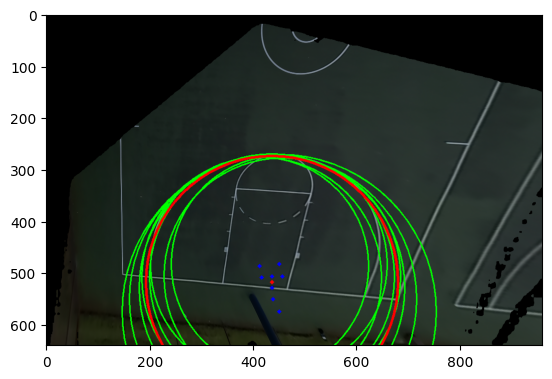

In [11]:
import copy
right_img_gray_with_circle = copy.deepcopy(right_img)
right_img_gray_with_circle = cv2.resize(right_img_gray_with_circle, edge_size)
circles = np.uint16(np.around(circle))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(right_img_gray_with_circle,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(right_img_gray_with_circle,(i[0],i[1]),2,(0,0,255),3)

# average the number of circles
average_radius = int(np.mean(circles[0, :, 2]))
average_x = int(np.mean(circles[0, :,0]))
average_y = int(np.mean(circles[0, :,1])) 

print(average_x)

cv2.circle(right_img_gray_with_circle, (average_x, average_y), average_radius, (255,0,0), 3)
cv2.circle(right_img_gray_with_circle, (average_x, average_y), 2, (255,0,0), 3)

plt.imshow(right_img_gray_with_circle)

In [12]:
# split lines

left_lines, right_lines, h_lines = classify_court_elements([average_x, average_y, average_radius], lines, average_radius/2, None)

vertical lines: [array([145, 254, 146, 469], dtype=int32), array([341, 521, 363, 352], dtype=int32), array([342, 521, 368, 329], dtype=int32), array([343, 520, 369, 325], dtype=int32), array([467, 532, 494, 412], dtype=int32), array([468, 534, 510, 345], dtype=int32), array([478, 490, 511, 345], dtype=int32), array([475, 504, 516, 326], dtype=int32), array([483, 475, 516, 332], dtype=int32), array([619, 547, 647, 446], dtype=int32), array([688, 522, 772, 342], dtype=int32), array([674, 553, 831, 218], dtype=int32), array([676, 553, 869, 140], dtype=int32), array([678, 553, 871, 139], dtype=int32), array([758, 383, 872, 139], dtype=int32), array([776, 347, 873, 139], dtype=int32), array([790, 563, 893, 377], dtype=int32), array([820, 247, 870, 139], dtype=int32), array([826, 243, 875, 139], dtype=int32), array([856, 445, 920, 331], dtype=int32)]


In [13]:
right_lines

[array([619, 547, 647, 446], dtype=int32),
 array([688, 522, 772, 342], dtype=int32),
 array([674, 553, 831, 218], dtype=int32),
 array([676, 553, 869, 140], dtype=int32),
 array([678, 553, 871, 139], dtype=int32),
 array([758, 383, 872, 139], dtype=int32),
 array([776, 347, 873, 139], dtype=int32),
 array([790, 563, 893, 377], dtype=int32),
 array([820, 247, 870, 139], dtype=int32),
 array([826, 243, 875, 139], dtype=int32),
 array([856, 445, 920, 331], dtype=int32)]

In [14]:
h_lines 
# left_lines

[array([384, 337, 510, 346], dtype=int32),
 array([368, 337, 514, 347], dtype=int32),
 array([368, 338, 514, 349], dtype=int32),
 array([149, 502, 551, 538], dtype=int32),
 array([147, 503, 682, 550], dtype=int32),
 array([152, 505, 681, 552], dtype=int32),
 array([370, 525, 678, 552], dtype=int32),
 array([530, 540, 679, 553], dtype=int32)]

In [15]:
left_lines

[array([145, 254, 146, 469], dtype=int32)]

In [16]:
from scipy.stats import linregress
def compute_intersection(line1, line2):
    # x1, y1 = line1
    # x2, y2 = line2    
    slope1, intercept1, r1, p1, se1 = linregress([line1[0], line1[2]], [line1[1], line1[3]])
    slope2, intercept2, r2, p2, se2 = linregress([line2[0], line2[2]], [line2[1], line2[3]])
    
    x_intersection = (intercept2 - intercept1) / (slope1 - slope2)
    y_intersection = slope1 * x_intersection + intercept1

    return x_intersection, y_intersection

In [20]:
import random
from skimage.feature import canny
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter


def fine_court(image, left_lines, right_lines, horizontal_lines, max_iter):
    court_width = 1524
    court_length = 1524
    offset = 0
    hough_radii = [724, 675, 602]
    dst_points = np.array([
        [0, offset],                  # Bottom-left corner
        [0, 579 + offset],       # Top-left corner
        [1524, offset + 579],  # Top-right corner
        [1524, offset]         # Bottom-right corner
    ], dtype=np.float32)
    
    # The expected center of the 3-point arc in the standardized view
    # The 3-point arc is centered at the basket position
    expected_arc_center_x = 1524 / 2  # Center of the court width
    expected_arc_center_y = 160  # Distance from baseline (adjust based on court specs)
    min_vertical_dist = 50
    
    # Initialize best score and best model variables
    best_score = float('inf')
    best_homography = None
    best_corners = None
    best_left_line = None
    best_right_line = None
    best_horizontal_lines = None
    
    # RANSAC iterations
    for _ in range(max_iter):
        if True:
            # 1. Random Sampling
            # Select one line from left candidates
            left_line = random.choice(left_lines)
            
            # Select one line from right candidates
            right_line = random.choice(right_lines)
            
            # Select two different horizontal lines with sufficient vertical distance
            valid_pair = False
            attempts = 0
            free_throw_line = None
            base_line = None
            while not valid_pair and attempts < 10000:
                horiz_line1, horiz_line2 = random.sample(horizontal_lines, 2)
                
                # Calculate vertical distance between the two horizontal lines
                y1_avg = (horiz_line1[1] + horiz_line1[3]) / 2
                y2_avg = (horiz_line2[1] + horiz_line2[3]) / 2
                vert_dist = abs(y1_avg - y2_avg)
                
                if vert_dist >= min_vertical_dist:
                    valid_pair = True
                    if y1_avg < y2_avg:
                        free_throw_line = horiz_line1
                        base_line = horiz_line2
                    else:
                        free_throw_line = horiz_line2
                        base_line = horiz_line1
                
                attempts += 1
            
            if not valid_pair:
                continue  # Skip this iteration if we couldn't find a valid pair
            
            # 2. Corner Computation
            # Compute intersections (corners)
            print("left line: ", left_line)
            print("right line: ", right_line)
            print("free throw line: ", free_throw_line)
            print("base: ", base_line)
            bl_corner = compute_intersection(left_line, base_line)  # Bottom-left
            tl_corner = compute_intersection(left_line, free_throw_line)  # Top-left
            br_corner = compute_intersection(right_line, base_line)  # Bottom-right
            tr_corner = compute_intersection(right_line, free_throw_line)  # Top-right
            
            # Check if any intersection failed
            if None in [bl_corner, tl_corner, br_corner, tr_corner]:
                continue
            
            x_bl, y_bl = bl_corner
            x_tl, y_tl = tl_corner
            x_br, y_br = br_corner
            x_tr, y_tr = tr_corner
            
            # Check if corners are within image bounds
            h, w = image.shape[:2]
            if not (0 <= x_bl < w and 0 <= y_bl < h and
                    0 <= x_tl < w and 0 <= y_tl < h and
                    0 <= x_br < w and 0 <= y_br < h and
                    0 <= x_tr < w and 0 <= y_tr < h):
                continue  # Corners outside image bounds, skip this iteration
            
            # Check if the corners form a valid quadrilateral (not self-intersecting)
            # This is a simplified check - horizontal lines should be arranged consistently
            if ((y_tl < y_bl and y_tr < y_br) or 
                (y_tl > y_bl and y_tr > y_br)):
                pass
            else:
                continue  # Invalid quadrilateral, skip this iteration
            
            # The corners in the image
            src_points = np.array([
                [x_bl, y_bl],  # Bottom-left
                [x_tl, y_tl],  # Top-left
                [x_tr, y_tr],  # Top-right
                [x_br, y_br]   # Bottom-right
            ], dtype=np.float32)
            
            # 3. Transformation Estimation
            # Compute homography
            homography, _ = cv2.findHomography(src_points, dst_points)
            
            # 4. Bird-Eye View Processing
            # Warp the image
            warped_img = cv2.warpPerspective(image, homography, (int(court_width), int(court_length)))
            plt.imshow(warped_img)
            plt.show()

            edge_image = canny(warped_img, sigma=3)
            plt.imshow(edge_image)
            plt.show()

            # Detect two radii
            hough_res = hough_circle(edge_image, hough_radii)

            # Select the most prominent 3 circles
            accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=3)

            # Draw them
            fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
            rgb_image = color.gray2rgb(warped_img)
            for center_y, center_x, radius in zip(cy, cx, radii):
                circy, circx = circle_perimeter(center_y, center_x, radius, shape=rgb_image.shape)
                rgb_image[circy, circx] = (220, 20, 20)

            ax.imshow(rgb_image, cmap=plt.cm.gray)
            plt.show()
            
            # # Convert to grayscale if necessary
            # if len(warped_img.shape) == 3:
            #     warped_gray = cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)
            # else:
            #     warped_gray = warped_img
            
            # # Apply some preprocessing to enhance circle detection
            # warped_gray = cv2.GaussianBlur(warped_gray, (5, 5), 0)
            
            # # Circle Detection using Hough Circle Transform
            # # Parameters for circle detection
            # dp = 2
            # min_dist = int(court_width / 10)  # Minimum distance between circle centers
            # param1 = 50  # Upper threshold for the internal Canny edge detector
            # param2 = 30  # Threshold for center detection
            # min_radius = int(court_width / 4)  # Minimum circle radius
            # max_radius = int(court_width / 2)  # Maximum circle radius
            
            # circles = cv2.HoughCircles(
            #     warped_gray, cv2.HOUGH_GRADIENT, dp, min_dist,
            #     param1=param1, param2=param2,
            #     minRadius=min_radius, maxRadius=max_radius
            # )
            
            # # Skip if no circles detected
            # if circles is None:
            #     continue
            
            # 5. Scoring the Sample
            # Find the best circle (closest to expected position)
            best_circle_score = float('inf')
            best_circle = None
            
            for center_y, center_x, radius in zip(cy, cx, radii):
                # print x, y, r
                
                # Calculate distance to expected center
                distance = np.sqrt((center_x - expected_arc_center_x) ** 2 + (center_y - expected_arc_center_y) ** 2)
                print("center distance is: ", distance)
                if distance < best_circle_score:
                    best_circle_score = distance
                    best_circle = circle
            
            # Update best model if this sample has a better score
            if best_circle_score < best_score:
                best_score = best_circle_score
                best_homography = homography
                best_corners = [(x_bl, y_bl), (x_tl, y_tl), (x_tr, y_tr), (x_br, y_br)]
                best_left_line = left_line
                best_right_line = right_line
                best_horizontal_lines = [horiz_line1, horiz_line2]
            if best_score < 10:
                break
            

    
    if best_homography is None:
        raise ValueError("Failed to find a valid court model with the given input lines.")
    
    return best_homography, best_corners, best_left_line, best_right_line, best_horizontal_lines


left line:  [145 254 146 469]
right line:  [619 547 647 446]
free throw line:  [368 337 514 347]
base:  [147 503 682 550]


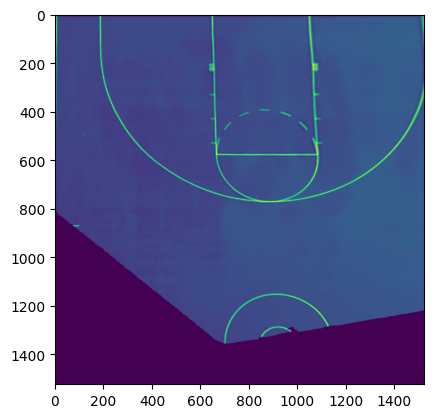

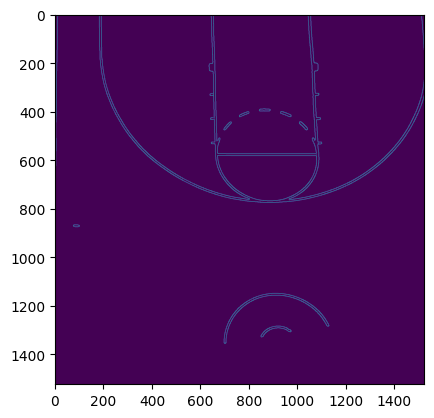

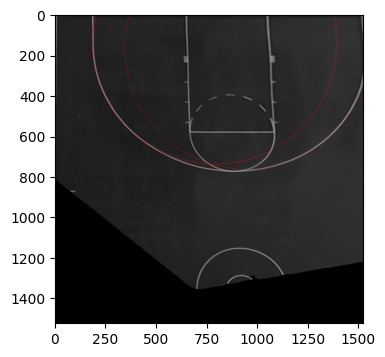

center distance is:  32.526911934581186
center distance is:  40.36087214122113
center distance is:  184.00271737123884
left line:  [145 254 146 469]
right line:  [678 553 871 139]
free throw line:  [368 338 514 349]
base:  [149 502 551 538]


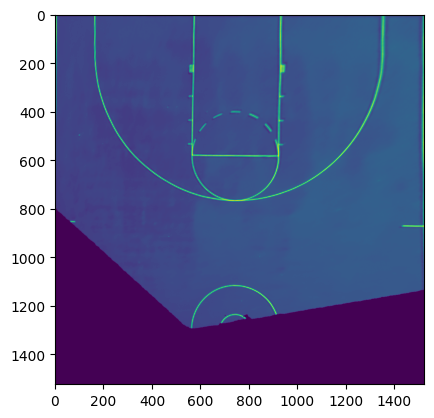

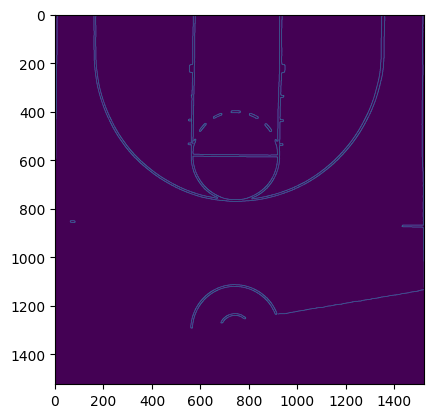

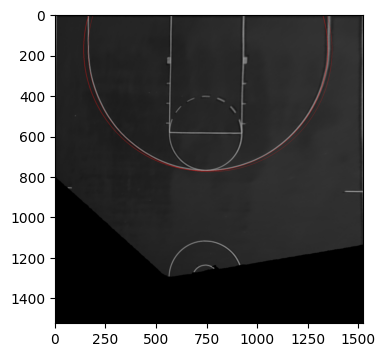

center distance is:  13.152946437965905
center distance is:  20.12461179749811
center distance is:  22.360679774997898
left line:  [145 254 146 469]
right line:  [820 247 870 139]
free throw line:  [384 337 510 346]
base:  [152 505 681 552]


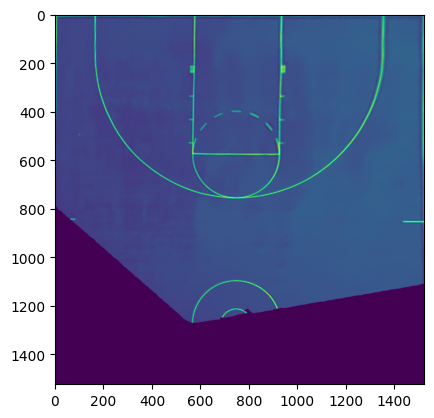

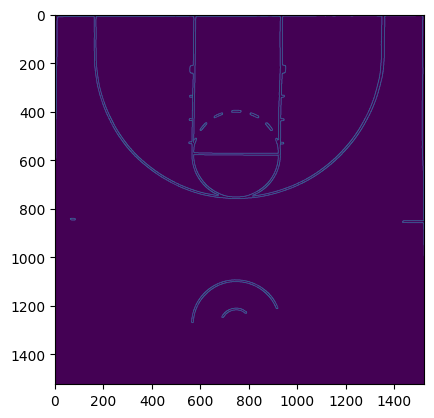

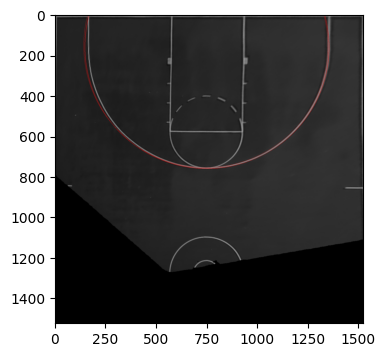

center distance is:  20.615528128088304
center distance is:  14.142135623730951
center distance is:  12.36931687685298
left line:  [145 254 146 469]
right line:  [758 383 872 139]
free throw line:  [384 337 510 346]
base:  [530 540 679 553]


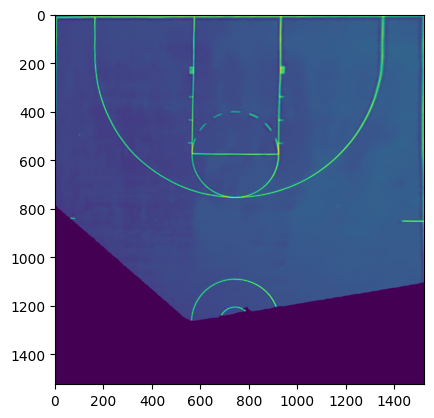

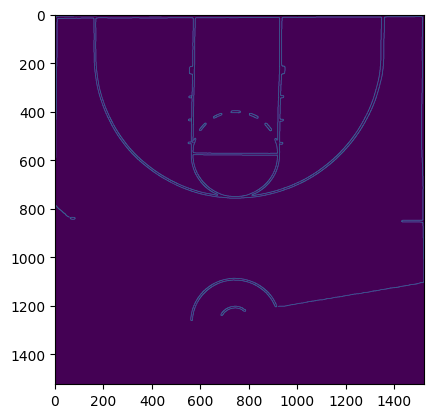

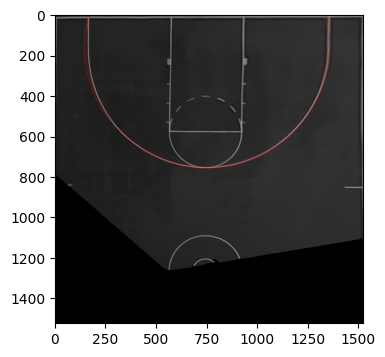

center distance is:  21.95449840010015
center distance is:  14.212670403551895
center distance is:  14.866068747318506
left line:  [145 254 146 469]
right line:  [688 522 772 342]
free throw line:  [384 337 510 346]
base:  [149 502 551 538]


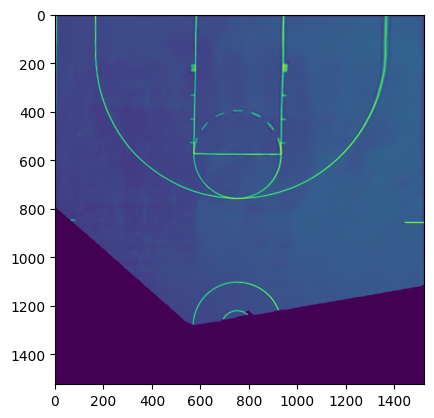

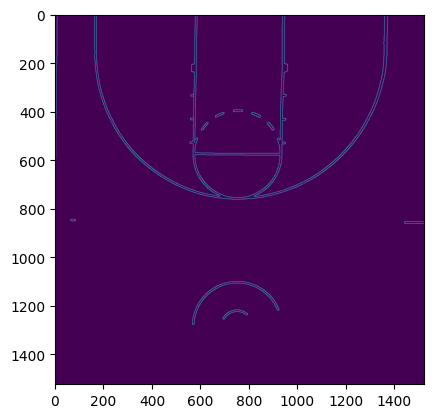

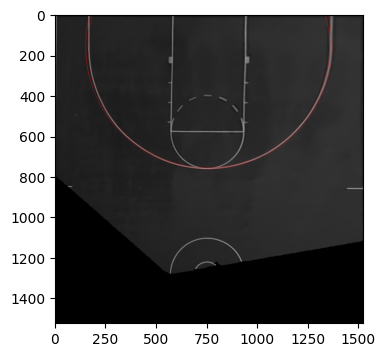

center distance is:  13.038404810405298
center distance is:  8.0
center distance is:  5.830951894845301


(array([[ 2.16099402e+00, -1.00510708e-02, -3.10791167e+02],
        [ 2.34884748e-01, -2.62288193e+00,  1.28168894e+03],
        [ 1.25648799e-04, -6.09680901e-04,  1.00000000e+00]]),
 [(np.float64(146.15230224321132), np.float64(501.74498229043456)),
  (np.float64(145.30674642738452), np.float64(319.95048188767396)),
  (np.float64(761.741935483871), np.float64(363.9815668202764)),
  (np.float64(675.3371537726839), np.float64(549.134670487106))],
 array([145, 254, 146, 469], dtype=int32),
 array([688, 522, 772, 342], dtype=int32),
 [array([384, 337, 510, 346], dtype=int32),
  array([149, 502, 551, 538], dtype=int32)])

In [21]:
fine_court(right_img_gray, left_lines, right_lines, h_lines, 100)